In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
#import dataset from csv
data = pd.read_csv('bitcoin_price_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

Get basic statistics of the dataset

In [3]:
data.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


Timestamp is not in datetime format to make it human readable. So, Let's change that.

In [4]:
# Convert timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
# Set datetime as index
data.set_index("Timestamp", inplace=True)

In [5]:
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Time is in minute by minute so let's resample the data into daily prices

In [6]:
# Resample data to daily
data = data.resample('1D').mean()

In [7]:
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [8]:
#count toal number of rows
data.count()

Open                 3376
High                 3376
Low                  3376
Close                3376
Volume_(BTC)         3376
Volume_(Currency)    3376
Weighted_Price       3376
dtype: int64

In [9]:
data.isna().sum()

Open                 3
High                 3
Low                  3
Close                3
Volume_(BTC)         3
Volume_(Currency)    3
Weighted_Price       3
dtype: int64

There are some missing values so fill them with forward filling (missing value filled with the value of the previous row)

In [10]:
# Forward fill missing data
data.fillna(method='ffill', inplace=True)

In [11]:
data.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [12]:
# Number of days to predict + 1
t_intervals = 4
dt = 1  # Increment, which is daily in this case

In [13]:
# Split data into train and test
train = data[:-t_intervals]
test = data[-t_intervals:]

Return (profit) is calculated by taking the difference between today and yesterday.

In [14]:
#  Calculate log returns of the train set
train['LogReturn'] = np.log(train['Weighted_Price']) - np.log(train['Weighted_Price'].shift(1))

/tmp/ipykernel_257271/2479961275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['LogReturn'] = np.log(train['Weighted_Price']) - np.log(train['Weighted_Price'].shift(1))


In [15]:
# Calculate drift and diffusion parameters on the train set
mu = train['LogReturn'].mean()
sigma = train['LogReturn'].std(ddof=1)

In [16]:
# Initialize the future price series
future_price = np.zeros_like(np.arange(t_intervals))

In [17]:
# Set the last known price in the train set as the starting point of the prediction
future_price[0] = train['Weighted_Price'][-1]

In [18]:
# Generate random series for the prediction
np.random.seed(1)
random_series = norm.ppf(np.random.rand(t_intervals))

In [19]:
# Using the model to predict future prices for the next 3 days
for t in range(1, t_intervals):
    future_price[t] = future_price[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*random_series[t])

In [20]:
# Compare the predicted prices with the actual prices in the test set
test['Predicted_Price'] = future_price 

/tmp/ipykernel_257271/1619352060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Price'] = future_price


In [21]:
#drop the first row of the test set
test = test[1:]

In [22]:
# Print test set to see the predicted and actual prices
print(test[['Weighted_Price', 'Predicted_Price']])

            Weighted_Price  Predicted_Price
Timestamp                                  
2021-03-29    56913.993819            56569
2021-03-30    58346.912268            49149
2021-03-31    58764.349363            48272


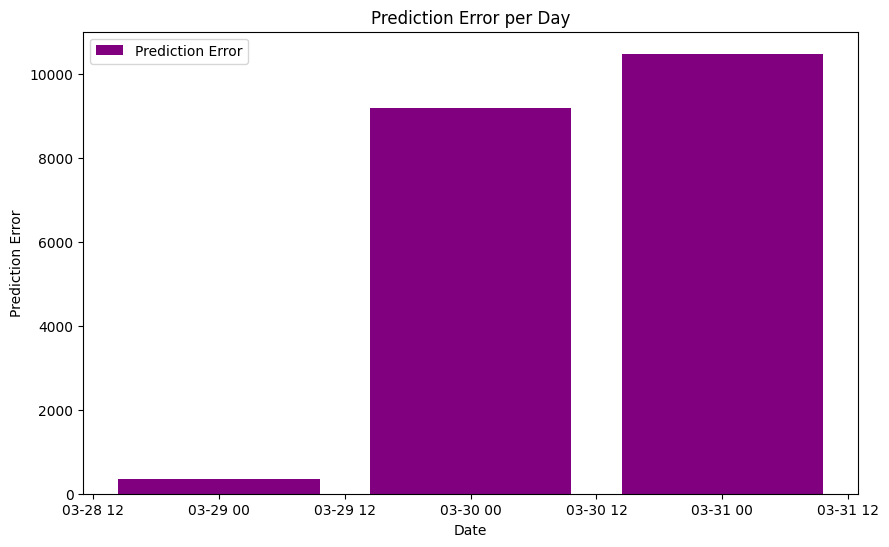

In [23]:
# Calculate errors
errors = test['Weighted_Price'] - test['Predicted_Price']

# Plot the results
plt.figure(figsize=(10,6))
plt.bar(test.index.date, errors, color='purple', label='Prediction Error')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title('Prediction Error per Day')
plt.legend()
plt.show()


In [24]:
# Calculate errors
mae = mean_absolute_error(test['Weighted_Price'], test['Predicted_Price'])
mse = mean_squared_error(test['Weighted_Price'], test['Predicted_Price'])
rmse = sqrt(mse) 

# MAPE isn't available in sklearn, so we'll calculate it manually
mape = np.mean(np.abs((test['Weighted_Price'] - test['Predicted_Price']) / test['Weighted_Price'])) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MAE: 6678.418483519102
MSE: 64936668.66194523
RMSE: 8058.329148275418
MAPE: 11.408434675813627%
